In [1]:
# Install required libraries (if not already installed)
!pip install imbalanced-learn xgboost

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

In [3]:
# Upload dataset manually in Colab
from google.colab import files
uploaded = files.upload()

# Load the dataset (Ensure correct filename)
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

Saving healthcare_fraud_detection_dataset.csv to healthcare_fraud_detection_dataset.csv


In [4]:
# Display dataset information
print(df.head())
print(df.info())

   Patient_ID  Provider_ID  Claim_Amount Diagnosis_Code Procedure_Code  \
0       10000          602      40193.79           D004           P200   
1       10001          935      46468.48           D002           P300   
2       10002          848      20314.62           D003           P500   
3       10003          770      45314.94           D004           P400   
4       10004          606      16142.64           D004           P300   

   Claim_Date  Patient_Age  Previous_Claims  Hospitalization_Duration  \
0  2025-02-19           22               15                        13   
1  2023-10-25           21                9                         6   
2  2025-03-20           18               14                        10   
3  2025-03-03           73                3                         0   
4  2024-07-19           62               11                         5   

   Doctor_Visits  Prescription_Count  Fraud_Label  
0              7                   1            0  
1           

In [5]:
# Check for missing values
print("\nMissing Values:\n", df.isnull().sum())

# Drop unnecessary ID columns if they exist
columns_to_drop = ['Patient_ID', 'Provider_ID']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')


Missing Values:
 Patient_ID                  0
Provider_ID                 0
Claim_Amount                0
Diagnosis_Code              0
Procedure_Code              0
Claim_Date                  0
Patient_Age                 0
Previous_Claims             0
Hospitalization_Duration    0
Doctor_Visits               0
Prescription_Count          0
Fraud_Label                 0
dtype: int64


In [6]:
# Convert Claim_Date to datetime and extract features
if 'Claim_Date' in df.columns:
    df['Claim_Date'] = pd.to_datetime(df['Claim_Date'])
    df['Claim_Year'] = df['Claim_Date'].dt.year
    df['Claim_Month'] = df['Claim_Date'].dt.month
    df['Claim_Day'] = df['Claim_Date'].dt.day
    df.drop(columns=['Claim_Date'], inplace=True)

In [7]:
# Encoding categorical variables
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [8]:
# Define features (X) and target variable (y)
X = df.drop(columns=['Fraud_Label'])
y = df['Fraud_Label']

In [9]:
# Check class imbalance
print("\nClass Distribution:\n", y.value_counts())


Class Distribution:
 Fraud_Label
0    4265
1     735
Name: count, dtype: int64


<ipython-input-10-1ed4cc8980f6>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette=['green', 'red'])


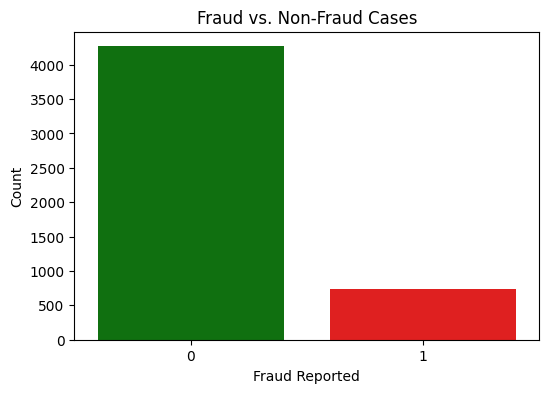

In [10]:
# Visualizations

# 1. Fraud Distribution (Bar Chart)
plt.figure(figsize=(6,4))
sns.countplot(x=y, palette=['green', 'red'])
plt.title("Fraud vs. Non-Fraud Cases")
plt.xlabel("Fraud Reported")
plt.ylabel("Count")
plt.show()

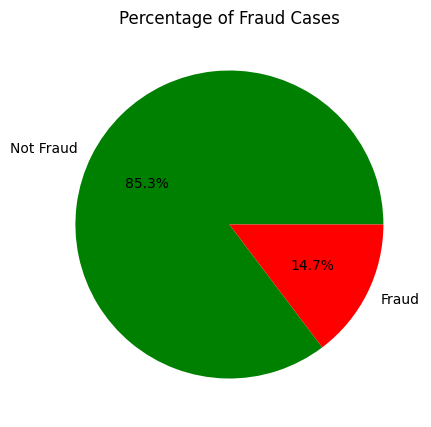

In [11]:
# 2. Fraud Distribution (Pie Chart)
plt.figure(figsize=(5,5))
y.value_counts().plot.pie(autopct='%1.1f%%', colors=['green', 'red'], labels=['Not Fraud', 'Fraud'])
plt.title("Percentage of Fraud Cases")
plt.ylabel("")
plt.show()

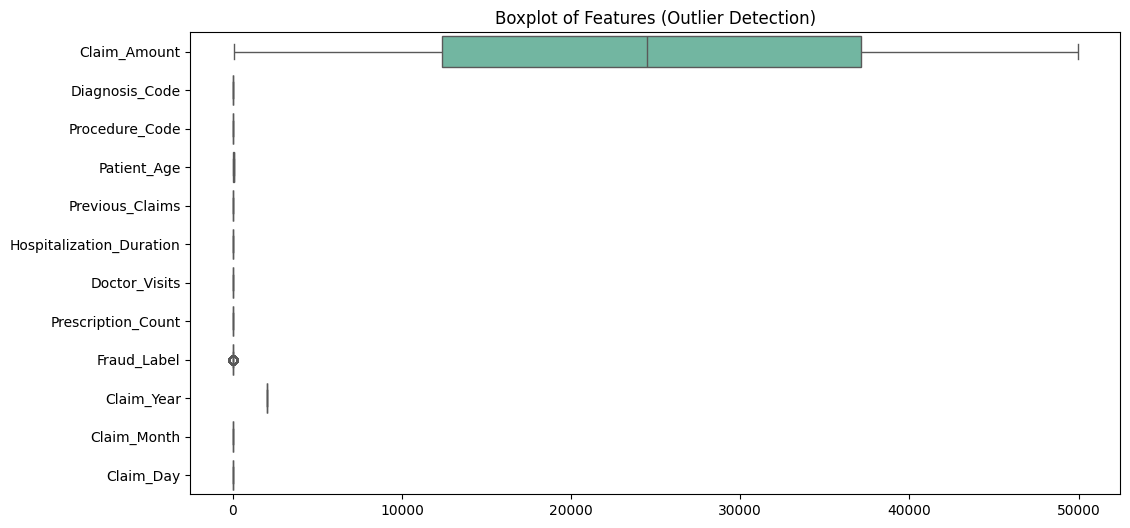

In [12]:
# 3. Boxplots for Outlier Detection
plt.figure(figsize=(12,6))
sns.boxplot(data=df, orient="h", palette="Set2")
plt.title("Boxplot of Features (Outlier Detection)")
plt.show()

In [13]:
# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [14]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [15]:
# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
# Train models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

In [17]:
# Evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred)

    print(f"\n{name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(classification_report(y_test, y_pred))


Logistic Regression Performance:
Accuracy: 0.6143
AUC-ROC: 0.6144
              precision    recall  f1-score   support

           0       0.61      0.62      0.61       841
           1       0.62      0.61      0.61       865

    accuracy                           0.61      1706
   macro avg       0.61      0.61      0.61      1706
weighted avg       0.61      0.61      0.61      1706


Random Forest Performance:
Accuracy: 0.8189
AUC-ROC: 0.8188
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       841
           1       0.82      0.82      0.82       865

    accuracy                           0.82      1706
   macro avg       0.82      0.82      0.82      1706
weighted avg       0.82      0.82      0.82      1706



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:10:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Performance:
Accuracy: 0.8417
AUC-ROC: 0.8414
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       841
           1       0.83      0.87      0.85       865

    accuracy                           0.84      1706
   macro avg       0.84      0.84      0.84      1706
weighted avg       0.84      0.84      0.84      1706



In [18]:
# Hyperparameter tuning for XGBoost
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}
grid_search = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid, cv=3)
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:10:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:10:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:10:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:10:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:10:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]})

In [20]:
# Best XGBoost model evaluation
best_xgb = grid_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
print("\nBest XGBoost Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_xgb):.4f}")
print(classification_report(y_test, y_pred_xgb))


Best XGBoost Model Performance:
Accuracy: 0.8517
AUC-ROC: 0.8514
              precision    recall  f1-score   support

           0       0.86      0.83      0.85       841
           1       0.84      0.87      0.86       865

    accuracy                           0.85      1706
   macro avg       0.85      0.85      0.85      1706
weighted avg       0.85      0.85      0.85      1706



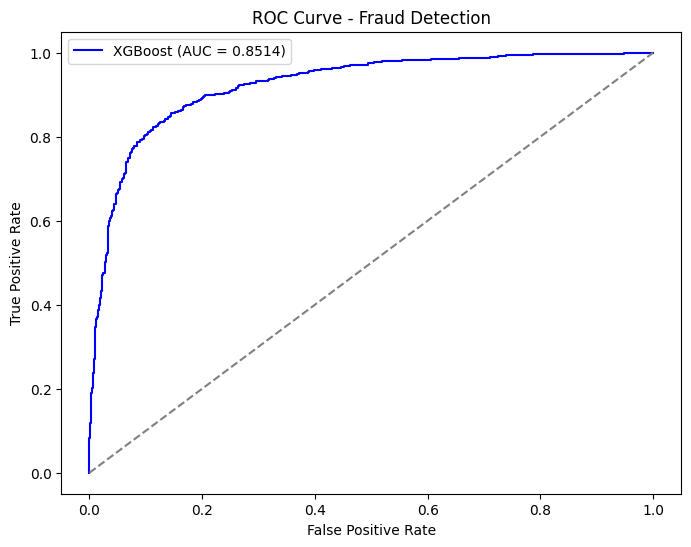

In [21]:
# ROC Curve Visualization
y_proba = best_xgb.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label="XGBoost (AUC = {:.4f})".format(roc_auc_score(y_test, y_pred_xgb)))
plt.plot([0, 1], [0, 1], linestyle="--", color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Fraud Detection")
plt.legend()
plt.show()